# Info
Name:  

    ORACLES_AOD_profile

Purpose:  

    Comparison of AOD from 4STAR over a profile
    Additional calculations of the aerosol extinction profile
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - load_utils.py : for loading OMI HDF5 files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - pytables
    - os
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, OSAN AFB, Korea, 2016-05-09
    Modified: Samuel LeBlanc, Swakopmund, Namibia, 2016-09-05
              ported from KORUS

# Import the required modules and set up base


In [1]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import tables
import load_utils as lm

In [2]:
%matplotlib notebook
fp = 'C:/Users/sleblan2/Research/ORACLES/'

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from mpl_toolkits.basemap import Basemap,cm
from Sp_parameters import deriv, smooth

# Load the various data

## Load the 4STAR starsun


In [24]:
dd = '20160831'

In [4]:
f_star = fp+'data\\4STAR_{}starsun.mat'.format(dd)

In [5]:
s = sio.loadmat(f_star)

In [6]:
s.keys()

['Str',
 'tau_O3_err',
 'sza',
 'm_ray',
 'toggle',
 'pitch',
 'Tst',
 'fwhm',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'nirheader',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'nirfilen',
 'm_err',
 'f',
 'tau_O4_err',
 'flagallcolsitems',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'flagallcols',
 'rate',
 'program_version',
 'sat_time',
 'm_O3',
 'visheader',
 'nirTint',
 'filename',
 'tau_r_err',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'darkstd',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_aero_err3',
 'tau_aero_err2',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'El_deg',
 'skyresp',
 'Lon',
 'tau_aero',
 'AZ_deg',
 'visrow_labels',
 'm_H2O',
 'c0err',
 'viscols',
 'tau_CO2_CH4_N2O_abserr',
 'flagitems',
 'aerosolcols',
 'tau_O3',
 'vissat_pixel',
 '

In [7]:
s['utc'] = lm.toutc(lm.mat2py_time(s['t']))

## Get the flag file

In [8]:
s_flag = 'C:\\Users\\sleblan2\\Research\\4STAR_codes\\data_folder\\{dd}_starflag_man_created20160904_1609by_SL.mat'.format(dd)

In [9]:
sf = sio.loadmat(s_flag)

In [10]:
sf.keys()

['unspecified_clouds',
 'manual_flags',
 'bad_aod',
 'flagfile',
 '__globals__',
 'frost',
 '__header__',
 'before_or_after_flight',
 'unspecified_aerosol',
 'hor_legs',
 'low_cloud',
 'smoke',
 'time',
 'dust',
 'vert_legs',
 '__version__',
 'cirrus']

In [63]:
sf['bad_aod']==0 and sf['unspecified_clouds']==0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
ifl = sf['unspecified_clouds']==0

In [56]:
ifl = (sf['bad_aod']==0) and (sf['unspecified_clouds']==0) and (sf['cirrus']==0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [65]:
ifl = ifl.flatten()

In [66]:
ifl.shape

(18075L,)

In [67]:
s['utc'].shape

(18075L,)

## Plot some early 4STAR data

<IPython.core.display.Javascript object>


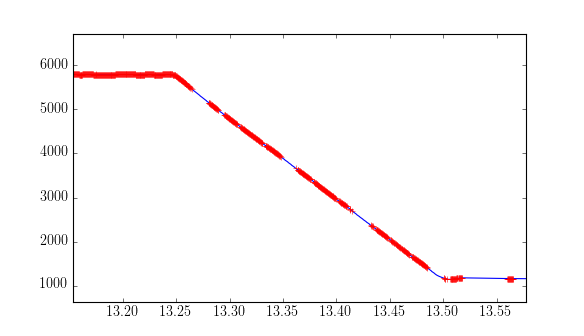

In [70]:
plt.figure()
plt.plot(s['utc'],s['Alt'])
plt.plot(s['utc'][ifl],s['Alt'][ifl],'+r')

<IPython.core.display.Javascript object>


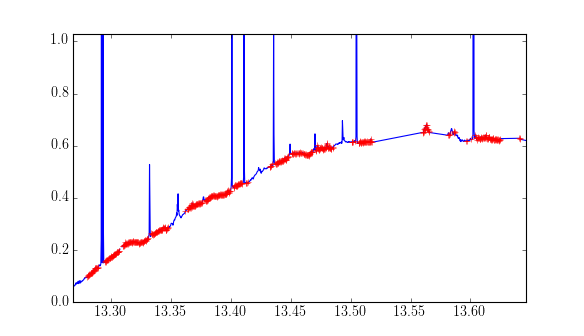

In [69]:
plt.figure()
plt.plot(s['utc'],s['tau_aero'][:,400])
plt.plot(s['utc'][ifl],s['tau_aero'][ifl,400],'+r')

<IPython.core.display.Javascript object>


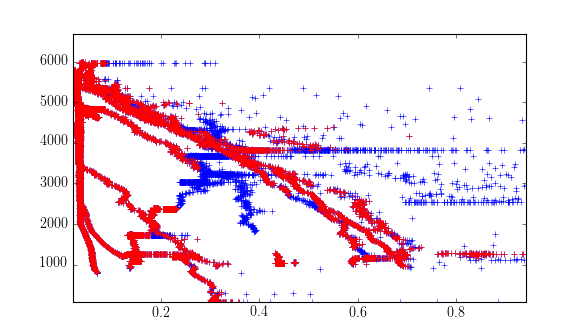

In [71]:
plt.figure()
plt.plot(s['tau_aero'][:,400],s['Alt'],'+')
plt.plot(s['tau_aero'][ifl,400],s['Alt'][ifl],'+r')


In [72]:
profile = [13.24,13.56]

In [73]:
it = (s['utc']>=profile[0]) & (s['utc']<=profile[1]) & (ifl) & (s['tau_aero'][:,400]<0.8)

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [74]:
it = it.flatten()

# Plot the geographical region and add context

In [102]:
#set up a easy plotting function
def make_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=14.0,lat_0=-22.0,
            llcrnrlon=-10.0, llcrnrlat=-25.0,
            urcrnrlon=20.0, urcrnrlat=0,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-10,20,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(-25,1,14),labels=[1,0,0,0])
    return m


<IPython.core.display.Javascript object>


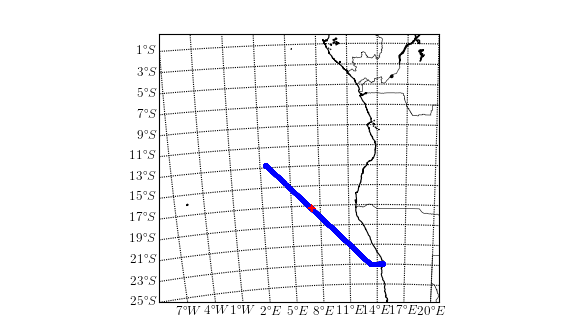

In [104]:
fig,ax = plt.subplots(1,1)
m = make_map(ax)
m.plot(s['Lon'],s['Lat'],'b.',latlon=True)
m.plot(s['Lon'][it],s['Lat'][it],'r+',latlon=True)
plt.savefig(fp+'plot\\map_take_off_profile_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Now plot the vertical distribution of AOD and Extinction

## Vertical profile of AOD

In [75]:
i515 = np.argmin(abs(s['w']*1000.0-515.0))

In [97]:
ii = np.where(it)[0][-3]

In [111]:
tau_max = 1.0

In [92]:
ii

12603

In [80]:
s['tau_aero'].shape

(18075L, 1556L)

<IPython.core.display.Javascript object>


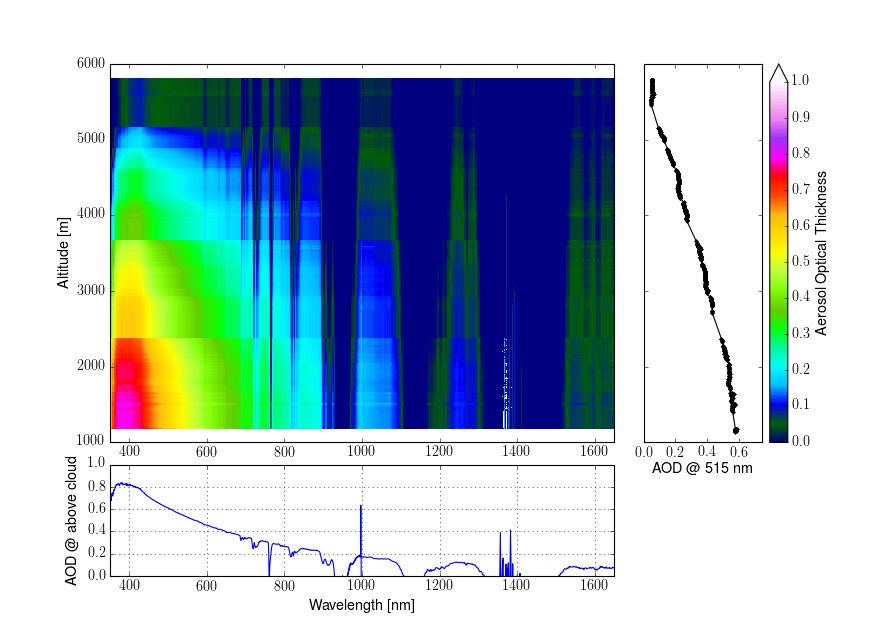

In [119]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)
ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'k.-')
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([1000,6000])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.2,0.4,0.6])
ax2.set_xlim([0.0,tau_max*0.75])
ax2.set_xlabel('AOD @ 515 nm')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][ii,:].flatten())
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax3.grid()
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD @ above cloud')
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot\\AOD_Alt_profile_{}.png'.format(dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


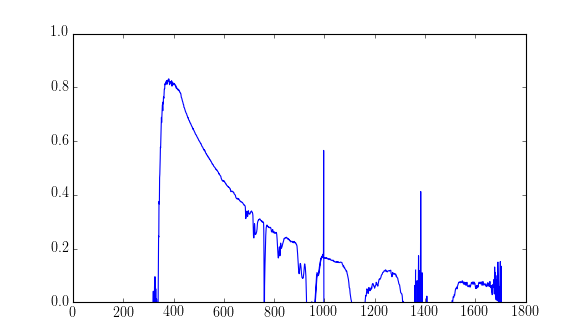

(0, 1)

In [105]:
plt.figure()
#for i in range(0,500,10):
plt.plot(s['w'].flatten()*1000.0,s['tau_aero'][ii+2,:])
plt.ylim([0,1])

## Vertical profile of extinction

In [114]:
from Sp_parameters import deriv,smooth

In [115]:
s['ext'] = np.zeros_like(s['tau_aero'])

In [116]:
for l,w in enumerate(s['w'][0]):
    s['ext'][it,l] = smooth(deriv(smooth(s['tau_aero'][it,l],3,nan=False,old=True),
                                  s['Alt'][it][:,0])*-1000000.0,5,nan=False,old=True)

Sp_parameters.py:107: RuntimeWarning: divide by zero encountered in true_divide
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:107: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:107: RuntimeWarning: overflow encountered in ushort_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x

<IPython.core.display.Javascript object>


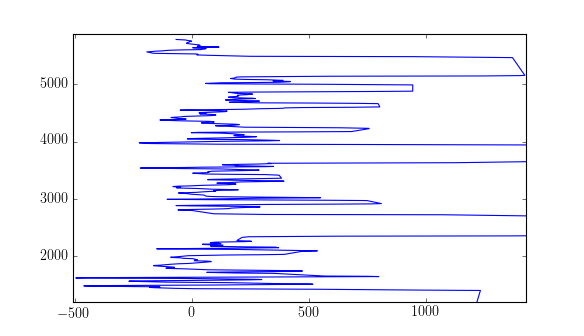

In [117]:
plt.figure()
plt.plot(s['ext'][it,400],s['Alt'][it])

<IPython.core.display.Javascript object>


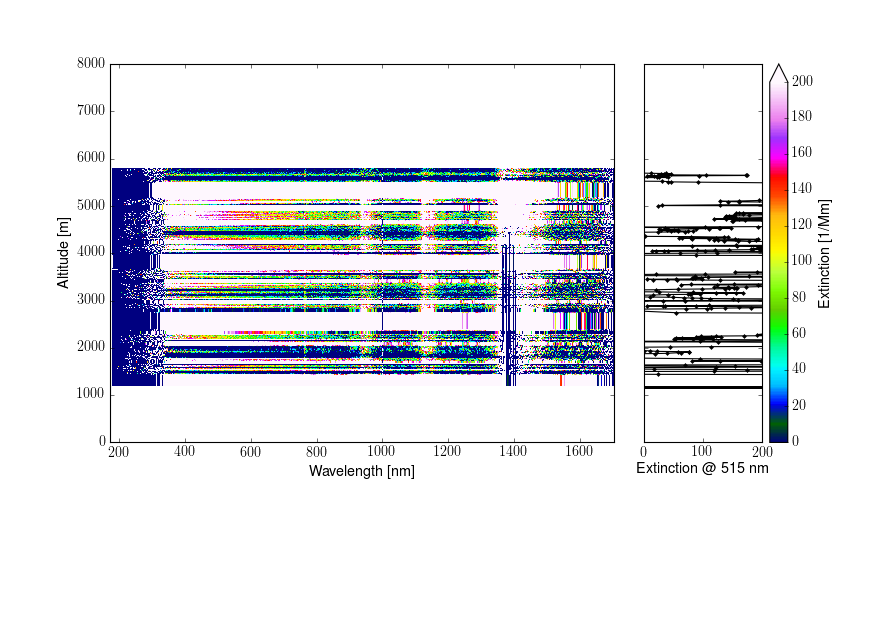

In [118]:
fig = plt.figure(figsize=(11,8))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['ext'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=200.0)
ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)
ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.-')
axc = plt.colorbar(cb,extend='max')
axc.set_label('Extinction [1/Mm]')
ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([0,8000])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,100.0,200.0])
ax2.set_xlim([0.0,200.0])
ax2.set_xlabel('Extinction @ 515 nm')

#ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
#ax3.plot(s['w'].flatten()*1000.0,s['ext'][ii,:].flatten())
#ax.set_xlim([350,1650])
#ax3.set_ylim([0,200.0])
#ax3.grid()
#ax3.set_xlabel('Wavelength [nm]')
#ax3.set_ylabel('AOT')
#plt.setp(ax.get_xticklabels(), visible=False)
plt.savefig(fp+'plot\\Ext_Alt_profile_{dd}.png'.format(dd=dd),dpi=600,transparent=True)